# Ordinal Rank Prediction with One-Hot Encoding and `mord.LogisticIT`

## Overview

Aim to predict the risk rank (an integer from 1 to 265, where lower rank = higher risk) for multiple subjects over time. Key objectives include:

* Ordinal Prediction: Because the rank is inherently ordered, we use an ordinal logistic regression model (mord.LogisticIT).
* Handling Categorical Drivers: Each subject has 17 driver variables (Driver1–Driver17), each with categories (Factor1, Factor2, …). We avoid imposing a numeric order by one-hot encoding these categorical factors.
* Time-Series & Panel Data: Each subject is observed at irregular timestamps, so we incorporate lag features (PrevRank) and time-based splitting to mimic real-world forecasting.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Ordinal logistic regression
# pip install mord
from mord import LogisticIT

# For computing spearman correlation
from scipy.stats import spearmanr

Steps:
1. Load & sort data by SubjectID, UpdateDT

2. Create 'PrevRank' as a legitimate lag feature

3. One-hot encode the 17 driver columns

4. Add time-based features (DaysFromEarliest, TimeDiff)

5. Time-based split

6. Hyperparameter tuning for LogisticIT (alpha)

7. Evaluate best model with MSE, MAE, Spearman correlation

8. Inspect final coefficients

In [3]:
# 1) LOAD & SORT DATA

file_path="Rank.csv"

df = pd.read_csv(file_path)
df["UpdateDT"] = pd.to_datetime(df["UpdateDT"])
df.sort_values(["SubjectID", "UpdateDT"], inplace=True)

In [45]:
df.head()

,SubjectID,Rank,Driver1,Driver2,Driver3,Driver4,Driver5,Driver6,Driver7,Driver8,...,Driver10,Driver11,Driver12,Driver13,Driver14,Driver15,Driver16,Driver17,UpdateDT,PrevRank
1022,1,189,Factor6,Factor14,Factor7,Factor16,Factor1,Factor13,Factor11,Factor10,...,Factor12,Factor17,Factor9,Factor3,Factor5,Factor8,Factor4,Factor2,2021-05-06 14:13:00,189.0
2100,1,170,Factor6,Factor14,Factor7,Factor16,Factor1,Factor12,Factor17,Factor13,...,Factor9,Factor15,Factor8,Factor10,Factor3,Factor4,Factor2,Factor5,2021-05-15 21:41:00,189.0
3401,1,203,Factor6,Factor7,Factor16,Factor14,Factor1,Factor17,Factor11,Factor10,...,Factor13,Factor12,Factor9,Factor3,Factor8,Factor4,Factor5,Factor2,2021-05-24 10:53:00,170.0
4114,1,176,Factor6,Factor7,Factor16,Factor14,Factor1,Factor17,Factor11,Factor10,...,Factor12,Factor15,Factor9,Factor3,Factor8,Factor4,Factor5,Factor2,2021-06-02 13:51:00,203.0
5680,1,184,Factor6,Factor14,Factor1,Factor7,Factor13,Factor16,Factor12,Factor17,...,Factor9,Factor15,Factor10,Factor3,Factor4,Factor8,Factor5,Factor2,2021-06-13 22:57:00,176.0


<class 'pandas.core.frame.DataFrame'>
Index: 31933 entries, 1022 to 31881
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SubjectID  31933 non-null  int64         
 1   Rank       31933 non-null  int64         
 2   Driver1    31933 non-null  object        
 3   Driver2    31933 non-null  object        
 4   Driver3    31933 non-null  object        
 5   Driver4    31933 non-null  object        
 6   Driver5    31933 non-null  object        
 7   Driver6    31933 non-null  object        
 8   Driver7    31933 non-null  object        
 9   Driver8    31933 non-null  object        
 10  Driver9    31933 non-null  object        
 11  Driver10   31933 non-null  object        
 12  Driver11   31933 non-null  object        
 13  Driver12   31933 non-null  object        
 14  Driver13   31933 non-null  object        
 15  Driver14   31933 non-null  object        
 16  Driver15   31933 non-null  object        


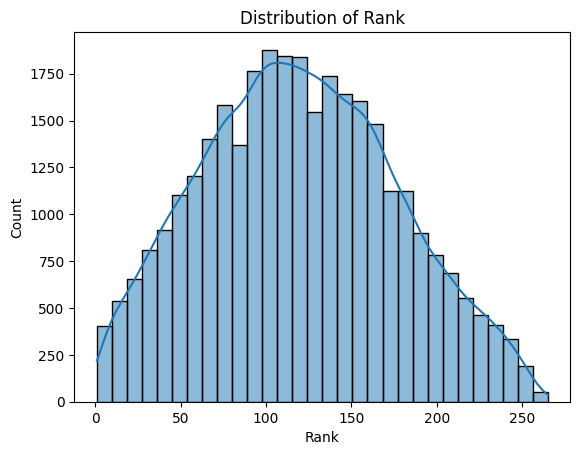

In [4]:
print(df.info())
print(df.describe(include="all"))

# Let's also check the distribution of Rank
sns.histplot(df["Rank"], kde=True, bins=30)
plt.title("Distribution of Rank")
plt.show()

## Feature Engineering & Preprocessing

Time-order is crucial for any form of forecasting or sequential feature engineering (e.g., creating PrevRank). We ensure each subject’s observations are in chronological order. We must ensure we don’t leak the target from the current measurement, so we do NOT create something like DeltaRank = Rank(t) - Rank(t-1).

### One-Hot Encoding for Drivers
We have 17 driver columns (Driver1–Driver17), each with categories like Factor1, Factor2, etc. We do one-hot (dummy) encoding to avoid imposing an artificial numeric order. Label encoding would treat Factor2 > Factor1 in a numeric sense. One-hot just says “this row has Factor2 for DriverX” or “doesn’t have Factor2,” etc.

### Additional Time-Based Features

- DaysFromEarliest: The offset in days from the earliest date in the dataset. might capture any overall trend (rank shifting over months).
- TimeDiff: The gap in days between consecutive observations for each subject. helps if the time spacing itself influences rank changes.


In [5]:
# 2) CREATE LAG FEATURE: PrevRank

df["PrevRank"] = df.groupby("SubjectID")["Rank"].shift(1)
# Fill the first measurement’s PrevRank with that row’s own Rank
df["PrevRank"] = df["PrevRank"].fillna(df["Rank"])

In [6]:
# 3) ONE-HOT ENCODE DRIVERS

# Identify all driver columns
driver_cols = [col for col in df.columns if col.startswith("Driver")]

# Because these are nominal features (Factor1, Factor2, ...),
# we do pd.get_dummies to avoid imposing an artificial order.
# We'll do it on the entire DataFrame for simplicity, then filter out
# columns we don't need (SubjectID, Rank, etc.). Alternatively,
# you can isolate just driver columns and get_dummies on that subset.
df_encoded = pd.get_dummies(
    data=df,
    columns=driver_cols,  # specify the columns to encode
    prefix=driver_cols,   # optional prefix
    drop_first=True       # avoid dummy trap by dropping 1 category per driver
)
# Note: 'drop_first=True' reduces dimension by 1 for each driver.

# The result is a DataFrame with many new columns: Driver1_Factor2, Driver1_Factor3, etc.


In [7]:
# 4) TIME-BASED FEATURES

earliest_date = df_encoded["UpdateDT"].min()
df_encoded["DaysFromEarliest"] = (df_encoded["UpdateDT"] - earliest_date).dt.days

# Time difference since previous row for each subject
df_encoded["TimeDiff"] = df_encoded.groupby("SubjectID")["UpdateDT"].diff().dt.days
df_encoded["TimeDiff"] = df_encoded["TimeDiff"].fillna(0)

# Our target is the same: "Rank"
# We'll keep the numeric columns we need plus the newly created one-hot columns.

# We'll define a feature list that excludes SubjectID, Rank, UpdateDT, etc.
# But includes PrevRank, TimeDiff, DaysFromEarliest, and all driver dummy columns.
exclude_cols = ["SubjectID", "Rank", "UpdateDT"]
all_cols = list(df_encoded.columns)
feature_cols = [
    c for c in all_cols
    if c not in exclude_cols
    # Already included in the data but let's ensure we keep these:
    # 'PrevRank', 'TimeDiff', 'DaysFromEarliest'
]

target_col = "Rank"

# Drop rows that might still have NaN in feature_cols or target (unlikely)
df_encoded.dropna(subset=feature_cols + [target_col], inplace=True)

## Time-Based Train/Test Split

For time-series data, train on older data and test on newer data—simulating real forecasting. We pick the 80th percentile of UpdateDT as the cutoff. We must reflect real-world scenario: we can’t train on future data to predict the past.

In [8]:

# 5) TIME-BASED SPLIT

cutoff_date = df_encoded["UpdateDT"].quantile(0.80)
train_df = df_encoded[df_encoded["UpdateDT"] <= cutoff_date]
test_df = df_encoded[df_encoded["UpdateDT"] > cutoff_date]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

## Modeling: Ordinal Logistic Regression
We’ll use mord’s LogisticIT, which supports the ordinal nature of our target rank.

### Hyperparameter Tuning of alpha

LogisticIT has a regularization parameter alpha. Loop over a few candidate values, fit on the training set, then measure MAE on the test set to pick the best one.

In [10]:
# 6) HYPERPARAMETER TUNING (alpha)

alphas = [50.0] # [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]
best_alpha = None
best_mae = float("inf")
best_model = None

print("Tuning alpha for LogisticIT...\n")

# for alpha_val in alphas:
model_temp = LogisticIT(alpha=alpha_val)
model_temp.fit(X_train, y_train)
y_pred_temp = model_temp.predict(X_test)

mae_temp = np.mean(abs(y_pred_temp - y_test))
if mae_temp < best_mae:
    best_mae = mae_temp
    best_alpha = alpha_val
    best_model = model_temp

print(f"  alpha={alpha_val:<5} => Test MAE={mae_temp:.2f}")

print(f"\nBest alpha: {best_alpha} with MAE = {best_mae:.2f}")

Tuning alpha for LogisticIT...

  alpha=50.0  => Test MAE=37.75

Best alpha: 50.0 with MAE = 37.75


Spearman correlation captures how well we preserve rank ordering

In [11]:
# 7) EVALUATE BEST MODEL

final_model = best_model
y_pred = final_model.predict(X_test)

mse = np.mean((y_pred - y_test) ** 2)
mae = np.mean(abs(y_pred - y_test))
spearman_corr, _ = spearmanr(y_pred, y_test)

print("\n--- Final Model Evaluation ---")
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")


--- Final Model Evaluation ---
Test MSE: 2303.14
Test MAE: 37.75
Spearman Correlation: 0.725


## Visualizationing results:

Since we used one-hot encoding, each driver is split into multiple dummy columns. We can approximate each driver’s “importance” by summing the absolute coefficient values of all its dummy columns. Large sums of absolute coefficients suggest the driver’s categories have a strong effect on the model’s final rank predictions.

### Factor-Level Effects for a Single Driver
If we want to see how specific factor categories (e.g., Driver17_Factor2) shift rank relative to the baseline (usually Factor1), we can filter feature_effects.

A positive coefficient means that factor (relative to Factor1) pushes the rank higher (safer).
A negative coefficient (if present) means that factor is correlated with a lower (riskier) rank.


--- Coefficients from Ordinal Model (LogisticIT) ---
               Feature  Coefficient
260   Driver17_Factor2     4.458569
263   Driver17_Factor5     3.737941
262   Driver17_Factor4     3.678003
249   Driver16_Factor4     3.619147
261   Driver17_Factor3     3.381180
247   Driver16_Factor2     3.325264
250   Driver16_Factor5     3.160015
266   Driver17_Factor8     3.074106
252   Driver16_Factor7     3.060866
29     Driver2_Factor6     3.056730
253   Driver16_Factor8     3.047690
13     Driver1_Factor6     3.046266
61     Driver4_Factor6     2.993406
167  Driver11_Factor16     2.870361
248   Driver16_Factor3     2.794892
196  Driver13_Factor13     2.787395
149  Driver10_Factor14     2.778448
45     Driver3_Factor6     2.741330
179  Driver12_Factor12     2.729579
235   Driver15_Factor5     2.694537
66    Driver5_Factor11     2.688488
233   Driver15_Factor3     2.674552
237   Driver15_Factor7     2.669504
81    Driver6_Factor10     2.621935
151  Driver10_Factor16     2.615177
142    Dri

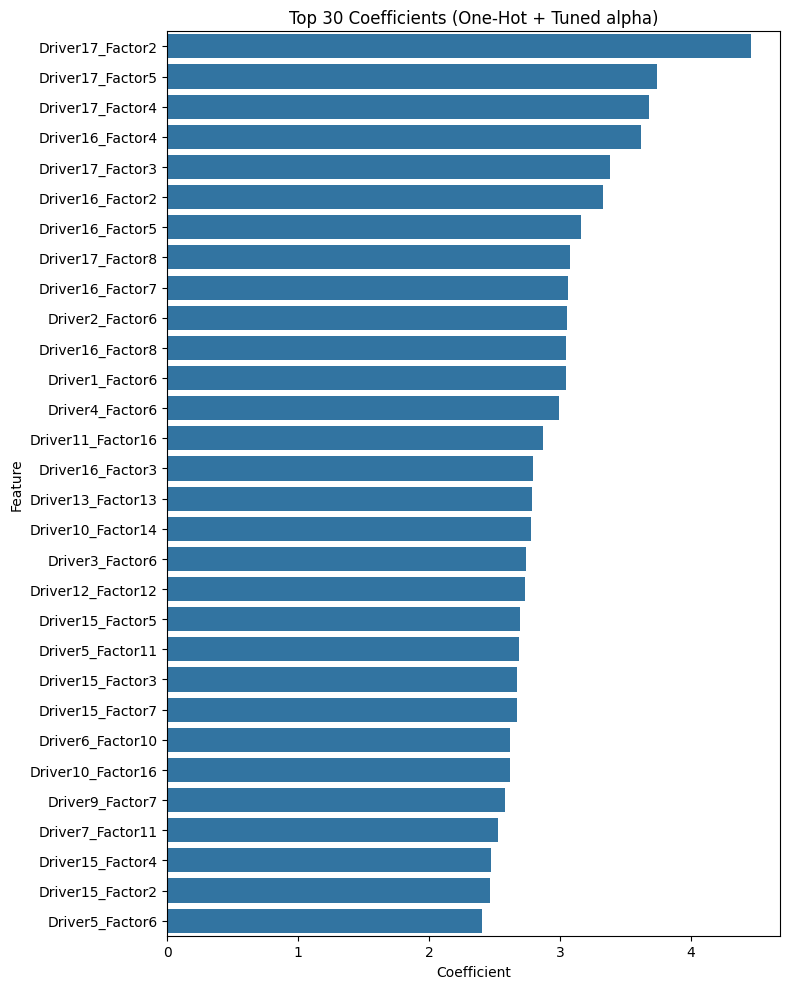

In [12]:
# 8) INSPECT FINAL COEFFICIENTS

# final_model.coef_ shape: (1, n_features)
coef_values = final_model.coef_.ravel()
feature_effects = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": coef_values
}).sort_values(by="Coefficient", ascending=False)

print("\n--- Coefficients from Ordinal Model (LogisticIT) ---")
print(feature_effects.head(30))  # print top 30 for brevity
print("...")

# Bar chart of the top ~30 largest magnitude coefficients
plt.figure(figsize=(8, 10))
top_30 = feature_effects.iloc[:30].copy()
sns.barplot(x="Coefficient", y="Feature", data=top_30, orient="h")
plt.title("Top 30 Coefficients (One-Hot + Tuned alpha)")
plt.tight_layout()
plt.show()

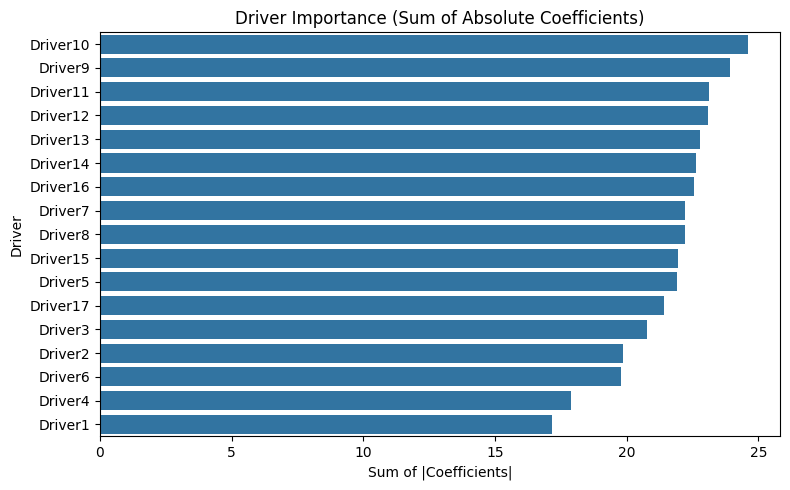

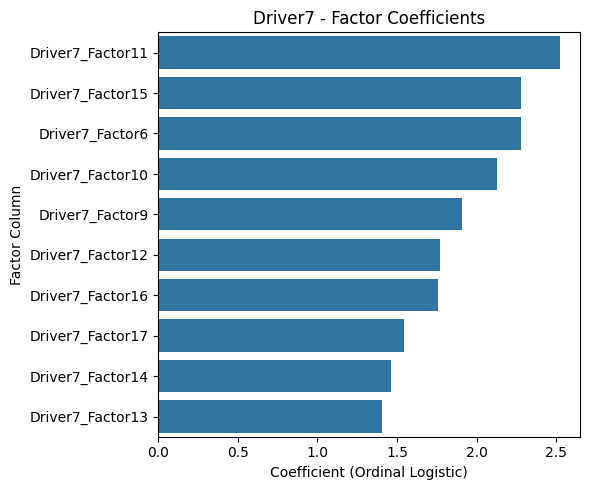

In [ ]:
def plot_driver_importances(feature_effects, top_n=17):
    """
    Aggregate the absolute coefficient magnitudes for each driver 
    to see which drivers are most important overall.
    feature_effects: DataFrame with columns [Feature, Coefficient]
    top_n: How many drivers to show (by total importance) 
           - you have 17 drivers; if you want them all, set top_n=17
    """
    # 1) Sum absolute coefficients by driver
    # One-hot columns typically look like 'DriverX_FactorY'
    # We'll extract 'DriverX' from each feature name using a regex or split.
    def get_driver_name(col):
        # e.g. 'Driver1_Factor2' -> 'Driver1'
        # e.g. 'PrevRank' or 'TimeDiff' or 'DaysFromEarliest' -> 'Other'
        match = re.match(r'(Driver\d+)_Factor.*', col)
        if match:
            return match.group(1)  # 'Driver1', 'Driver2', etc.
        else:
            return "Other"  # For PrevRank, TimeDiff, etc.

    # Apply this to each row in 'feature_effects'
    feature_effects["DriverGroup"] = feature_effects["Feature"].apply(get_driver_name)

    # Now group by that and sum absolute coefficient
    driver_importance = (
        feature_effects
        .groupby("DriverGroup")["Coefficient"]
        .apply(lambda x: x.abs().sum())  # sum of absolute values
        .reset_index(name="AbsCoeffSum")
    )

    # Filter out the "Other" group if you only want the actual drivers
    driver_importance = driver_importance[driver_importance["DriverGroup"] != "Other"]

    # Sort by descending total importance
    driver_importance.sort_values(by="AbsCoeffSum", ascending=False, inplace=True)

    # Show top N drivers
    driver_importance_top = driver_importance.head(top_n)

    # 2) Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=driver_importance_top,
        x="AbsCoeffSum",
        y="DriverGroup",
        orient="h"
    )
    plt.title("Driver Importance (Sum of Absolute Coefficients)")
    plt.xlabel("Sum of |Coefficients|")
    plt.ylabel("Driver")
    plt.tight_layout()
    plt.show()

def plot_driver_factors(feature_effects, driver_name="Driver12", top_k=10):
    """
    For a chosen driver (e.g. 'Driver17'), plot the coefficient 
    of each factor relative to the baseline factor.
    feature_effects: DataFrame with [Feature, Coefficient, ...]
    driver_name: e.g. 'Driver17'
    top_k: if you have many factors, you can limit how many to plot
    """
    # Filter only columns that start with 'Driver17_Factor'
    pattern = rf"{driver_name}_Factor"
    driver_subset = feature_effects[feature_effects["Feature"].str.startswith(pattern)]
    
    # Sort by descending coefficient
    driver_subset_sorted = driver_subset.sort_values(by="Coefficient", ascending=False)
    
    # Just show top K in the bar plot for clarity
    driver_top_k = driver_subset_sorted.head(top_k)

    plt.figure(figsize=(6, 5))
    sns.barplot(
        data=driver_top_k,
        x="Coefficient",
        y="Feature",
        orient="h"
    )
    plt.title(f"{driver_name} - Factor Coefficients")
    plt.xlabel("Coefficient (Ordinal Logistic)")
    plt.ylabel("Factor Column")
    plt.tight_layout()
    plt.show()



plot_driver_importances(feature_effects, top_n=17)
# Then pick a driver of interest, e.g. 'Driver17':
plot_driver_factors(feature_effects, driver_name="Driver7", top_k=10)
